In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from transformers import BertTokenizerFast, BertForTokenClassification
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import torch
from transformers import BertTokenizer, BertModel
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import numpy as np
import torch
import warnings
warnings.filterwarnings('ignore')

/home/jupyter/.local/lib/python3.10/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [2]:
df = pd.read_csv('mtsamples.csv')
df = df.drop(columns='Unnamed: 0')
df

,description,medical_specialty,sample_name,transcription,keywords
0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."
...,...,...,...,...,...
4994,Patient having severe sinusitis about two to ...,Allergy / Immunology,Chronic Sinusitis,"HISTORY:, I had the pleasure of meeting and e...",NaN
4995,This is a 14-month-old baby boy Caucasian who...,Allergy / Immunology,Kawasaki Disease - Discharge Summary,"ADMITTING DIAGNOSIS: , Kawasaki disease.,DISCH...","allergy / immunology, mucous membranes, conjun..."
4996,A female for a complete physical and follow u...,Allergy / Immunology,Followup on Asthma,"SUBJECTIVE: , This is a 42-year-old white fema...",NaN
4997,Mother states he has been wheezing and coughing.,Allergy / Immunology,Asthma in a 5-year-old,"CHIEF COMPLAINT: , This 5-year-old male presen...",NaN


# Анализ данных

In [39]:
train_df, test_df = train_test_split(df, random_state=42, stratify=df['keywords'].isnull())

print("Размер тренировочного набора:", train_df.shape)
print("Размер тестового набора:", test_df.shape)

Размер тренировочного набора: (3749, 5)
Размер тестового набора: (1250, 5)


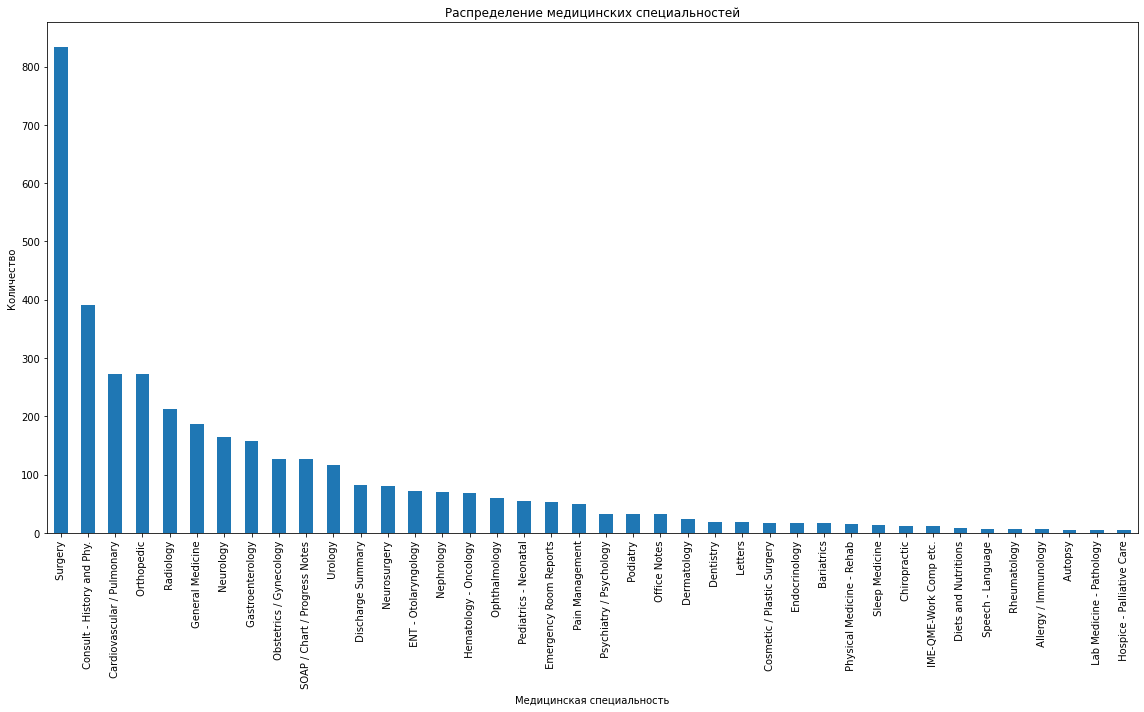

In [38]:
specialty_counts = train_df['medical_specialty'].value_counts()

plt.figure(figsize=(16,10))
specialty_counts.plot(kind='bar')
plt.title('Распределение медицинских специальностей')
plt.xlabel('Медицинская специальность')
plt.ylabel('Количество')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [40]:
len(train_df['medical_specialty'].value_counts())

40

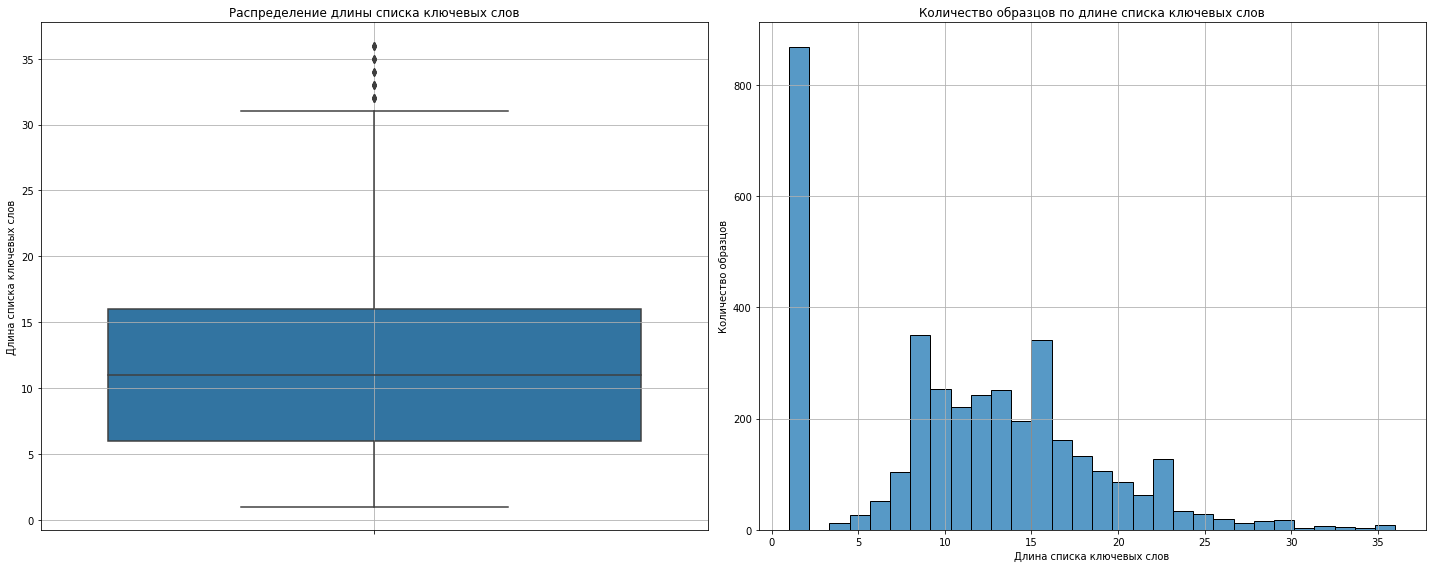

In [48]:
keyword_lengths = train_df['keywords'].apply(lambda x: len(str(x).split(',')))

plt.figure(figsize=(20,8))
plt.subplot(1, 2, 1)
sns.boxplot(y=keyword_lengths, data=train_df)
plt.title('Распределение длины списка ключевых слов')
plt.ylabel('Длина списка ключевых слов')
plt.grid(True)

plt.subplot(1, 2, 2)
sns.histplot(data=train_df, x=keyword_lengths, bins=30)
plt.title('Количество образцов по длине списка ключевых слов')
plt.xlabel('Длина списка ключевых слов')
plt.ylabel('Количество образцов')
plt.grid(True)

plt.tight_layout()
plt.show()

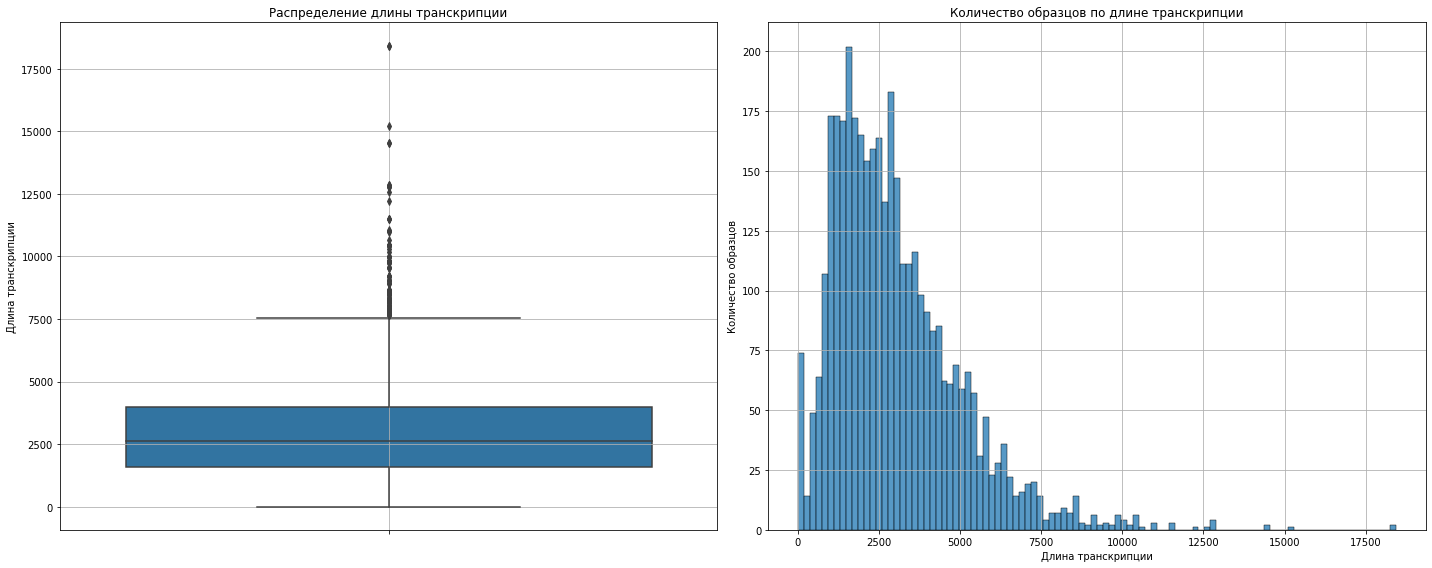

In [53]:
transcription_lengths = train_df['transcription'].apply(lambda x: len(str(x)))

plt.figure(figsize=(20,8))
plt.subplot(1, 2, 1)
sns.boxplot(y=transcription_lengths, data=train_df)
plt.title('Распределение длины транскрипции')
plt.ylabel('Длина транскрипции')
plt.grid(True)

plt.subplot(1, 2, 2)
sns.histplot(data=train_df, x=transcription_lengths, bins=100)
plt.title('Количество образцов по длине транскрипции')
plt.xlabel('Длина транскрипции')
plt.ylabel('Количество образцов')
plt.grid(True)

plt.tight_layout()
plt.show()

# BERT

## Предобработка данных

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import RobertaModel, RobertaTokenizer
from transformers import BertTokenizer
from keras.utils import pad_sequences

2024-04-21 18:09:30.448675: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
df = df.dropna(subset=['transcription'])
X = df['transcription'].tolist()
X = [str(text) for text in X if pd.notnull(text)]
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(df['medical_specialty'])
y = encoded_labels

In [5]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaModel.from_pretrained('roberta-base')

inputs = tokenizer(X, padding=True, truncation=True, return_tensors="pt", max_length=512)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def generate_embeddings(model, inputs, batch_size=16):
    model.eval()
    embeddings = []
    for i in tqdm(range(0, inputs['input_ids'].size(0), batch_size)):
        batch_input_ids = inputs['input_ids'][i:i+batch_size].to(device)
        batch_attention_mask = inputs['attention_mask'][i:i+batch_size].to(device)
        with torch.no_grad():
            batch_outputs = model(batch_input_ids, attention_mask=batch_attention_mask)
            batch_embeddings = batch_outputs.last_hidden_state.mean(dim=1)
            embeddings.append(batch_embeddings.cpu().numpy())
    embeddings = np.concatenate(embeddings, axis=0)
    return embeddings

embeddings = generate_embeddings(model, inputs)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 311/311 [00:49<00:00,  6.22it/s]


In [6]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
embeddings_resampled, labels_resampled = ros.fit_resample(embeddings, y)

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(embeddings_resampled, labels_resampled, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [8]:
class SimpleClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(SimpleClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [26]:
hidden_dim = 256
num_classes = np.unique(y).shape[0]
mlp_model = SimpleClassifier(input_dim=768, hidden_dim=hidden_dim, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

batch_size = 16
train_data = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
val_data = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))
train_loader = DataLoader(train_data, batch_size=batch_size)
val_loader = DataLoader(val_data, batch_size=batch_size)

## Обучение модели

In [36]:

from tqdm import tqdm
import numpy as np
from sklearn.metrics import f1_score

hidden_dims = [64, 128, 256]
learning_rates = 2
batch_sizes = [8, 16, 32]
best_hid, best_lr, best_size, best_f1 = 0, 0, 0, 0

for hidden_dim in hidden_dims:
    for lr in learning_rates:
        for batch_size in batch_sizes:
            print(f'hidden_dim: {hidden_dim}, lr: {lr}, batch_size: {batch_size}')
            mlp_model = SimpleClassifier(input_dim=768, hidden_dim=hidden_dim, num_classes=num_classes).to(device)
            optimizer = optim.Adam(mlp_model.parameters(), lr=lr)
            batch_size = batch_size
            train_data = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
            val_data = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))
            train_loader = DataLoader(train_data, batch_size=batch_size)
            val_loader = DataLoader(val_data, batch_size=batch_size)
            
            epochs = 5
            loss_values_train, loss_values_val, f1_values = [], [], []

            for epoch in range(epochs):
                mlp_model.train()
                total_loss = 0

                for batch in train_loader:

                    b_input_ids, b_labels = batch
                    b_input_ids = b_input_ids.to(device)
                    b_labels = b_labels.to(device)

                    optimizer.zero_grad() 

                    outputs = mlp_model(b_input_ids)

                    loss = criterion(outputs, b_labels)
                    total_loss += loss.item()

                    loss.backward()

                    optimizer.step()
                avg_train_loss = total_loss / len(train_loader)
                loss_values_train.append(avg_train_loss)


                mlp_model.eval()
                eval_loss = 0
                predictions, true_labels = [], []

                best_val_loss = float('inf')
                best_model_state = None

                for batch in val_loader:
                    b_input_ids, b_labels = batch
                    b_input_ids = b_input_ids.to(device)
                    b_labels = b_labels.to(device)

                    with torch.no_grad():
                        outputs = mlp_model(b_input_ids)

                    loss = criterion(outputs, b_labels)
                    eval_loss += loss.item()

                    
                    logits = outputs.detach().cpu().numpy()
                    label_ids = b_labels.to('cpu').numpy()
                    predictions.append(np.argmax(logits, axis=1))
                    true_labels.append(label_ids)

                eval_loss = eval_loss / len(val_loader)
                loss_values_val.append(eval_loss)
                predictions = np.concatenate(predictions)
                true_labels = np.concatenate(true_labels)
                f1 = f1_score(true_labels, predictions, average='weighted')
                f1_values.append(f1)

                print(f'Epoch {epoch + 1} | Train Loss: {avg_train_loss} | Val Loss: {eval_loss} | Val F1: {f1}')
                if f1 > best_f1:
                    best_hid, best_lr, best_size = hidden_dim, lr, batch_size
                    best_f1 = f1
                


hidden_dim: 64, lr: 0.01, batch_size: 8
Epoch 1 | Train Loss: 2.285255352802136 | Val Loss: 1.7960181869292522 | Val F1: 0.4243417705483359
Epoch 2 | Train Loss: 1.699459100881701 | Val Loss: 1.6319915666792761 | Val F1: 0.46170067845103707
Epoch 3 | Train Loss: 1.554153088703934 | Val Loss: 1.4648491096792413 | Val F1: 0.5172813150727212
Epoch 4 | Train Loss: 1.4974675417886865 | Val Loss: 1.6051532755715443 | Val F1: 0.4897607598169653
Epoch 5 | Train Loss: 1.4535189350683462 | Val Loss: 1.376980868222959 | Val F1: 0.5502032227700651
hidden_dim: 64, lr: 0.01, batch_size: 16
Epoch 1 | Train Loss: 2.030857041405112 | Val Loss: 1.4405264685697414 | Val F1: 0.5496658536494272
Epoch 2 | Train Loss: 1.3560940706919806 | Val Loss: 1.2275914127445395 | Val F1: 0.5890512431344717
Epoch 3 | Train Loss: 1.2257186130017919 | Val Loss: 1.186786358792554 | Val F1: 0.6109901661041265
Epoch 4 | Train Loss: 1.1528194867914505 | Val Loss: 1.085446226218825 | Val F1: 0.6416710687367757
Epoch 5 | Train 

In [37]:
print(best_hid, best_lr, best_size, best_f1)

256 0.001 16 0.7387151338518846


In [38]:
hidden_dim = 256
num_classes = np.unique(y).shape[0]
mlp_model = SimpleClassifier(input_dim=768, hidden_dim=hidden_dim, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

batch_size = 16
train_data = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
val_data = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))
train_loader = DataLoader(train_data, batch_size=batch_size)
val_loader = DataLoader(val_data, batch_size=batch_size)

In [39]:
from tqdm import tqdm
import numpy as np
from sklearn.metrics import f1_score


epochs = 30
loss_values_train, loss_values_val, f1_values = [], [], []

for epoch in range(epochs):
    mlp_model.train()
    total_loss = 0
    

    for batch in tqdm(train_loader, desc="Training", total=len(train_loader)):

        b_input_ids, b_labels = batch
        b_input_ids = b_input_ids.to(device)
        b_labels = b_labels.to(device)

        optimizer.zero_grad()

        outputs = mlp_model(b_input_ids)

        loss = criterion(outputs, b_labels)
        total_loss += loss.item()

        loss.backward()

        optimizer.step()
    avg_train_loss = total_loss / len(train_loader)
    loss_values_train.append(avg_train_loss)


    mlp_model.eval() 
    eval_loss = 0
    predictions, true_labels = [], []
    
    best_val_loss = float('inf')
    best_model_state = None
    
    for batch in tqdm(val_loader, desc="Validation", total=len(val_loader)):
        b_input_ids, b_labels = batch
        b_input_ids = b_input_ids.to(device)
        b_labels = b_labels.to(device)
        
        with torch.no_grad():

            outputs = mlp_model(b_input_ids)
        

        loss = criterion(outputs, b_labels)
        eval_loss += loss.item()


        logits = outputs.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        predictions.append(np.argmax(logits, axis=1))
        true_labels.append(label_ids)


    eval_loss = eval_loss / len(val_loader)
    loss_values_val.append(eval_loss)
    predictions = np.concatenate(predictions)
    true_labels = np.concatenate(true_labels)
    f1 = f1_score(true_labels, predictions, average='weighted')
    f1_values.append(f1)

    print(f'Epoch {epoch + 1} | Train Loss: {avg_train_loss} | Val Loss: {eval_loss} | Val F1: {f1}')

    if eval_loss < best_val_loss:
        best_val_loss = eval_loss
        best_model_state = mlp_model.state_dict()

Validation: 100%|██████████| 544/544 [00:00<00:00, 1146.05it/s]


Epoch 1 | Train Loss: 1.8831405301267903 | Val Loss: 1.1965141487581765 | Val F1: 0.6277311311783125


Validation: 100%|██████████| 544/544 [00:00<00:00, 1181.54it/s]


Epoch 2 | Train Loss: 1.0581847481502622 | Val Loss: 0.9493424095322981 | Val F1: 0.6920027840623416


Validation: 100%|██████████| 544/544 [00:00<00:00, 1167.04it/s]


Epoch 3 | Train Loss: 0.8787614154885066 | Val Loss: 0.8389202643404988 | Val F1: 0.7163895981989375


Validation: 100%|██████████| 544/544 [00:00<00:00, 1102.07it/s]


Epoch 4 | Train Loss: 0.7860073998899144 | Val Loss: 0.7753203409066534 | Val F1: 0.7255534690517383


Validation: 100%|██████████| 544/544 [00:00<00:00, 1153.02it/s]


Epoch 5 | Train Loss: 0.7273742229056855 | Val Loss: 0.7319500111728249 | Val F1: 0.736124393801589


Validation: 100%|██████████| 544/544 [00:00<00:00, 1180.95it/s]


Epoch 6 | Train Loss: 0.6866310106809524 | Val Loss: 0.7149963468477568 | Val F1: 0.7396388028238842


Validation: 100%|██████████| 544/544 [00:00<00:00, 1166.52it/s]


Epoch 7 | Train Loss: 0.6553930252489141 | Val Loss: 0.7020541662487256 | Val F1: 0.7467470269119135


Validation: 100%|██████████| 544/544 [00:00<00:00, 1165.17it/s]


Epoch 8 | Train Loss: 0.6293227987035233 | Val Loss: 0.68369884930058 | Val F1: 0.7546747582651108


Validation: 100%|██████████| 544/544 [00:00<00:00, 1110.00it/s]


Epoch 9 | Train Loss: 0.6104240188804254 | Val Loss: 0.6728281420792508 | Val F1: 0.7576920036373236


Validation: 100%|██████████| 544/544 [00:00<00:00, 1172.24it/s]


Epoch 10 | Train Loss: 0.594224910397886 | Val Loss: 0.6537061443223673 | Val F1: 0.7610081045562277


Validation: 100%|██████████| 544/544 [00:00<00:00, 1153.95it/s]


Epoch 11 | Train Loss: 0.5792663976614016 | Val Loss: 0.656490757198566 | Val F1: 0.7595650320871038


Validation: 100%|██████████| 544/544 [00:00<00:00, 1168.21it/s]


Epoch 12 | Train Loss: 0.5653422969786048 | Val Loss: 0.6502240507945638 | Val F1: 0.7563590354955048


Validation: 100%|██████████| 544/544 [00:00<00:00, 1153.38it/s]


Epoch 13 | Train Loss: 0.555724187507568 | Val Loss: 0.6602860743946889 | Val F1: 0.7587397957145169


Validation: 100%|██████████| 544/544 [00:00<00:00, 1114.08it/s]


Epoch 14 | Train Loss: 0.5446837484224827 | Val Loss: 0.6531928096733549 | Val F1: 0.7548040574412792


Validation: 100%|██████████| 544/544 [00:00<00:00, 1161.18it/s]


Epoch 15 | Train Loss: 0.5376368208067017 | Val Loss: 0.6584586802294806 | Val F1: 0.7561129850006499


Validation: 100%|██████████| 544/544 [00:00<00:00, 1179.66it/s]


Epoch 16 | Train Loss: 0.5285090138432661 | Val Loss: 0.641498230274438 | Val F1: 0.7641783469986114


Validation: 100%|██████████| 544/544 [00:00<00:00, 1192.67it/s]


Epoch 17 | Train Loss: 0.5208366419298246 | Val Loss: 0.6585834854255047 | Val F1: 0.757975787292199


Validation: 100%|██████████| 544/544 [00:00<00:00, 1163.35it/s]


Epoch 18 | Train Loss: 0.5143980035859653 | Val Loss: 0.64149363081464 | Val F1: 0.7634242191858679


Validation: 100%|██████████| 544/544 [00:00<00:00, 1086.77it/s]


Epoch 19 | Train Loss: 0.5072552716158623 | Val Loss: 0.6674267872209277 | Val F1: 0.7575657248040967


Validation: 100%|██████████| 544/544 [00:00<00:00, 1193.79it/s]


Epoch 20 | Train Loss: 0.5006914468546051 | Val Loss: 0.6705737527843345 | Val F1: 0.7573212746684017


Validation: 100%|██████████| 544/544 [00:00<00:00, 1172.00it/s]


Epoch 21 | Train Loss: 0.49538665530089215 | Val Loss: 0.6576527888640104 | Val F1: 0.7579051251797078


Validation: 100%|██████████| 544/544 [00:00<00:00, 1174.88it/s]


Epoch 22 | Train Loss: 0.49196484536115154 | Val Loss: 0.6613047717632178 | Val F1: 0.757784534541929


Validation: 100%|██████████| 544/544 [00:00<00:00, 1141.30it/s]


Epoch 23 | Train Loss: 0.4867369565432526 | Val Loss: 0.6730906983344432 | Val F1: 0.7579987647548121


Validation: 100%|██████████| 544/544 [00:00<00:00, 1121.13it/s]


Epoch 24 | Train Loss: 0.4820002785851887 | Val Loss: 0.6774193498251193 | Val F1: 0.7575211286922865


Validation: 100%|██████████| 544/544 [00:00<00:00, 1189.26it/s]


Epoch 25 | Train Loss: 0.4779423936041912 | Val Loss: 0.6909313666880789 | Val F1: 0.7473639430218467


Validation: 100%|██████████| 544/544 [00:00<00:00, 1173.29it/s]


Epoch 26 | Train Loss: 0.47330351960708333 | Val Loss: 0.696989950217197 | Val F1: 0.751501810137929


Validation: 100%|██████████| 544/544 [00:00<00:00, 1172.06it/s]


Epoch 27 | Train Loss: 0.4690559738128464 | Val Loss: 0.6963454537121031 | Val F1: 0.7525853064917103


Validation: 100%|██████████| 544/544 [00:00<00:00, 1150.75it/s]


Epoch 28 | Train Loss: 0.465773316803297 | Val Loss: 0.7069260919028345 | Val F1: 0.7526297747043039


Validation: 100%|██████████| 544/544 [00:00<00:00, 1135.75it/s]


Epoch 29 | Train Loss: 0.46432377021604526 | Val Loss: 0.7195405160789105 | Val F1: 0.7532613697651998


Validation: 100%|██████████| 544/544 [00:00<00:00, 1146.99it/s]

Epoch 30 | Train Loss: 0.45589940277768265 | Val Loss: 0.7516874838346506 | Val F1: 0.7391041070668484


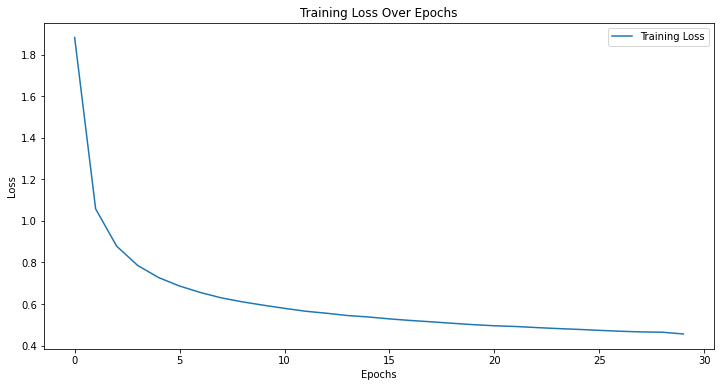

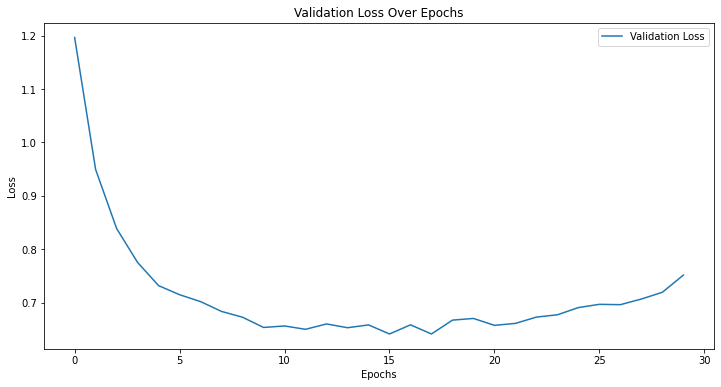

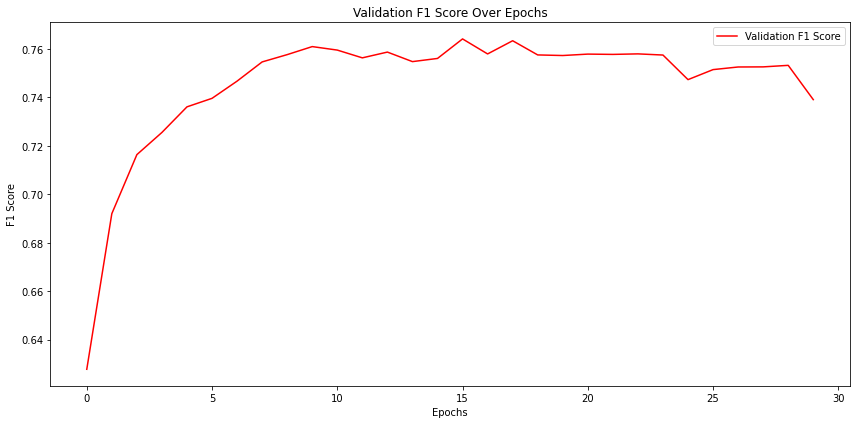

In [40]:
plt.figure(figsize=(12, 6))

plt.plot(loss_values_train, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.figure(figsize=(12, 6))

plt.plot(loss_values_val, label='Validation Loss')
plt.title('Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.figure(figsize=(12, 6))
plt.plot(f1_values, label='Validation F1 Score', color='red')
plt.title('Validation F1 Score Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

In [41]:
from sklearn.metrics import classification_report
import torch
from torch.utils.data import DataLoader, TensorDataset

mlp_model.load_state_dict(best_model_state)
mlp_model.to(device)
mlp_model.eval()

test_data = TensorDataset(torch.tensor(X_test, dtype=torch.float32).to(device), torch.tensor(y_test, dtype=torch.long).to(device))
test_loader = DataLoader(test_data, batch_size=8)

test_preds, test_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = mlp_model(inputs)
        preds = torch.argmax(outputs, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_pred_labels = encoder.inverse_transform(test_preds)
test_true_labels = encoder.inverse_transform(test_labels)

print("Classification Report on Test Set (Using Loaded Model):")
print(classification_report(test_true_labels, test_pred_labels))
report = classification_report(test_true_labels, test_pred_labels, output_dict=True)
macro_avg_f1 = report['macro avg']['f1-score']
weighted_avg_f1 = report['weighted avg']['f1-score']
print(f"Macro Average F1 Score: {macro_avg_f1}")
print(f"Weighted Average F1 Score: {weighted_avg_f1}")

Classification Report on Test Set (Using Loaded Model):
                                precision    recall  f1-score   support

          Allergy / Immunology       0.92      1.00      0.96       227
                       Autopsy       1.00      1.00      1.00       221
                    Bariatrics       0.96      0.77      0.86       230
    Cardiovascular / Pulmonary       0.47      0.50      0.48       204
                  Chiropractic       0.75      0.81      0.78       210
    Consult - History and Phy.       0.12      0.04      0.06       229
    Cosmetic / Plastic Surgery       0.74      0.85      0.79       208
                     Dentistry       0.95      0.85      0.90       229
                   Dermatology       0.80      0.96      0.87       213
          Diets and Nutritions       0.91      1.00      0.95       209
             Discharge Summary       0.59      0.55      0.57       214
          ENT - Otolaryngology       0.79      0.76      0.78       204
       

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np


print(classification_report(test_true_labels, test_pred_labels))
report = classification_report(test_true_labels, test_pred_labels, output_dict=True)


cm = confusion_matrix(test_true_labels, test_pred_labels)

                                precision    recall  f1-score   support

          Allergy / Immunology       0.92      1.00      0.96       227
                       Autopsy       1.00      1.00      1.00       221
                    Bariatrics       0.96      0.77      0.86       230
    Cardiovascular / Pulmonary       0.47      0.50      0.48       204
                  Chiropractic       0.75      0.81      0.78       210
    Consult - History and Phy.       0.12      0.04      0.06       229
    Cosmetic / Plastic Surgery       0.74      0.85      0.79       208
                     Dentistry       0.95      0.85      0.90       229
                   Dermatology       0.80      0.96      0.87       213
          Diets and Nutritions       0.91      1.00      0.95       209
             Discharge Summary       0.59      0.55      0.57       214
          ENT - Otolaryngology       0.79      0.76      0.78       204
        Emergency Room Reports       0.55      0.62      0.58  

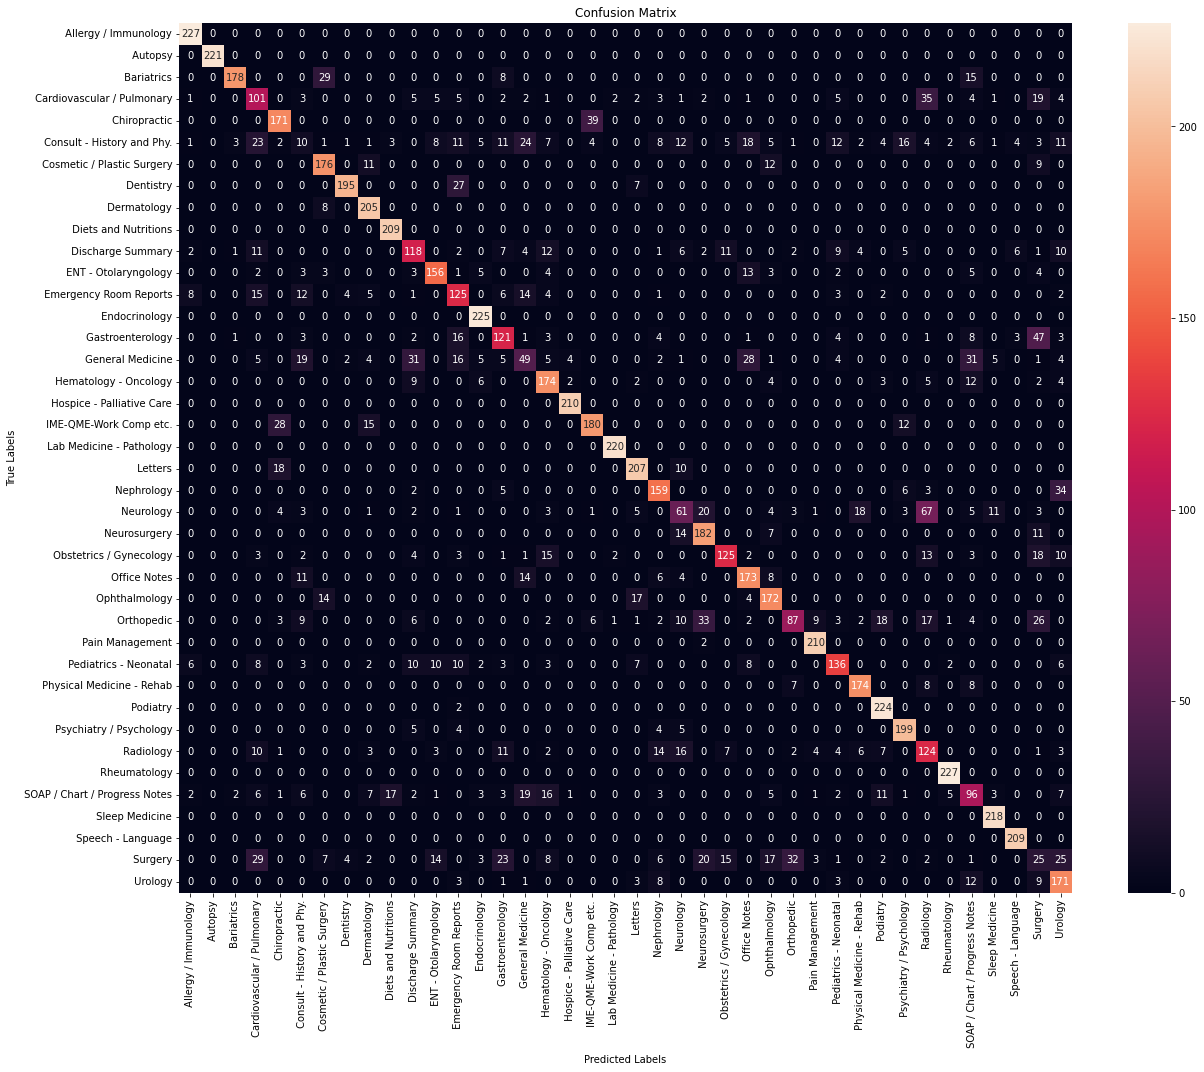

In [43]:
plt.figure(figsize=(20, 16))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=np.unique(test_true_labels), yticklabels=np.unique(test_true_labels))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

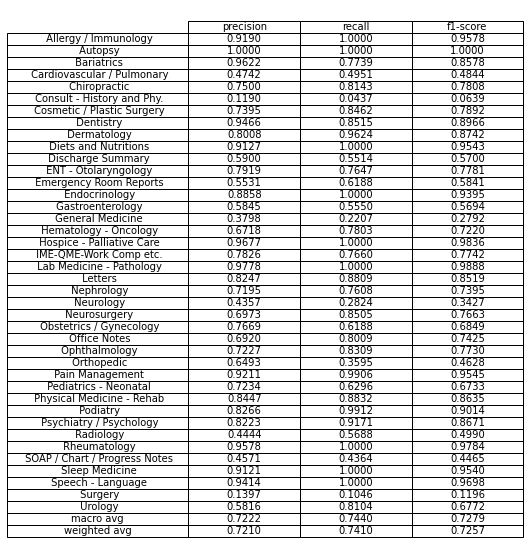

In [44]:
fig, ax = plt.subplots(figsize=(6, 10))
ax.axis('tight')
ax.axis('off')
formatted_cell_text = [
    [f"{value:.4f}" if isinstance(value, float) else f"{value}" for value in list(report[cls].values())[:-1]]
    for cls in report if cls != 'accuracy'
]

the_table = ax.table(
    cellText=formatted_cell_text,
    colLabels=['precision', 'recall', 'f1-score', 'support'],
    rowLabels=[cls for cls in report if cls != 'accuracy'],
    cellLoc='center', 
    rowLoc='center', 
    loc='center'
)

plt.show()
